In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
#from helper import plot_permute_importance, plot_feature_importance
    
from data_manip_fcn import data_manip

from imblearn.over_sampling import SMOTE

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [2]:
#import all 3 routes
route1 = pd.read_csv('data_route1/route1processeddata.csv')
route1['route'] = 1
route2 = pd.read_csv('data_route2/route2processeddata.csv')
route2['route'] = 2
route3 = pd.read_csv('data_route3/route3processeddata.csv')
route3['route'] = 3

# use function saved in library to categorize variables
df = data_manip(route1, route2, route3)

# Baseline model

In [3]:
# Random Classification Model
n = df.shape[0]
p = (df['count_cat'].value_counts() / n).values
y_pred = np.random.choice(len(p), n, p=p)
y = df['count_cat']

score = r2_score(y,y_pred)
acc = accuracy_score(y,y_pred)

print(f'R2:{score}, Accuracy:{acc}')

R2:-0.9853947521059885, Accuracy:0.5925496655076353


In [65]:
# Reduce to binary classification problem

df['count_cat'] = (df['count_cat'] > 0) * 1

features = ['DBT','weekend','precipitation_cat','Hour','Month']
target = 'count_cat'


# Drop observation that are really early or late
mask = (df['Hour'] > 6) & (df['Hour'] < 22)
data = df[mask]

X = data[features]
y = data[target]

X, y = SMOTE().fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=43)

baseline_model = LogisticRegression(max_iter = 1000)

baseline_model.fit(X_train,y_train)

train_pred = baseline_model.predict(X_train)
test_pred = baseline_model.predict(X_test)

tr_score = r2_score(y_train,train_pred)
tr_acc = accuracy_score(y_train,train_pred)

score = r2_score(y_test,test_pred)
acc = accuracy_score(y_test,test_pred)

print(f'Train R2:{tr_score}, Train Accuracy:{tr_acc}')
print(f'Test R2:{score}, Test Accuracy:{acc}')

Train R2:-0.6275757238749964, Train Accuracy:0.5931107154536536
Test R2:-0.6489367636365895, Test Accuracy:0.5877914370495972


# Boosting

In [10]:
# Set response variable
y = df['count_cat']
y_cont = df['count']

y_D = df['count_cat'][df['hour_cat'] != 0]
y_D_cont = df['count'][df['hour_cat'] != 0]

y_E = df['count_cat'][df['count'] != 0]
y_E_cont = df['count'][df['count'] != 0]

### PCA

In [11]:
# Create full set for PCA
X_P = df.drop(['Year','Day','Hour','Precipitation','utcivar1','utcivar2','utcivar3','count','route','count_cat'],axis =1)

# Adjust dummy variables
month_dm = pd.get_dummies(data=X_P['Month'], drop_first=True, prefix = 'month')
hour_cat_dm = pd.get_dummies(data=X_P['hour_cat'], drop_first=True, prefix = 'hour_cat')

X_P = pd.concat([X_P,hour_cat_dm,month_dm], axis=1).drop(['Month','hour_cat'], axis=1)

X_P.head()

,DBT,RelHum,WSp,Elev,specialdate,utcivar1_cat,precipitation_cat,weekend,hour_cat_1,hour_cat_4,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
2649,6.7,100.0,7.7,52.392654,0,-2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2650,6.7,96.0,8.2,58.334083,0,-2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2651,7.2,97.0,7.2,59.503749,0,-2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2652,6.7,100.0,8.2,55.398772,0,-2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2653,6.7,100.0,7.2,47.574727,0,-2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [12]:
# Train test split
X_trainA, X_test, y_trainA, y_test = train_test_split(X_P,y,train_size=0.8, random_state=109)

# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_trainA,y_trainA,train_size=0.9, random_state=109)

In [13]:
# Create and fit the standardized version of X
stScaler = StandardScaler().fit(X_train)
X_train_stScaled = stScaler.transform(X_train)
X_val_stScaled = stScaler.transform(X_val)
X_test_stScaled = stScaler.transform(X_test)

# Create and fit the full pca transformation
pcaSt = PCA().fit(X_train_stScaled)
X_train_pcaScaled = pcaSt.transform(X_train_stScaled)
X_val_pcaScaled = pcaSt.transform(X_val_stScaled)
X_test_pcaScaled = pcaSt.transform(X_test_stScaled)

# Convert to dataframes
X_train_pcaScaled_df = pd.DataFrame(X_train_pcaScaled)
X_val_pcaScaled_df = pd.DataFrame(X_val_pcaScaled)
X_test_pcaScaled_df = pd.DataFrame(X_test_pcaScaled)

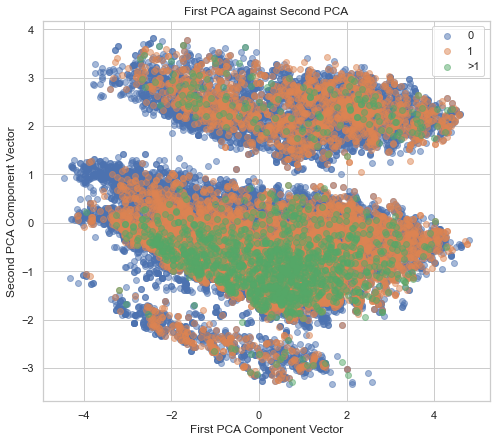

In [14]:
# Scatterplot between PCA1 and PCA2 of train

fig,ax =  plt.subplots(figsize = (8,7))

ax.scatter(X_train_pcaScaled_df[0][y_train.values == 0],X_train_pcaScaled_df[1][y_train.values == 0], alpha = 0.5)
ax.scatter(X_train_pcaScaled_df[0][y_train.values == 1],X_train_pcaScaled_df[1][y_train.values == 1], alpha = 0.5)
ax.scatter(X_train_pcaScaled_df[0][y_train.values > 1],X_train_pcaScaled_df[1][y_train.values > 1], alpha = 0.5)
ax.legend(["0","1", ">1"])
ax.set_title('First PCA against Second PCA',fontsize=12)
ax.set_xlabel("First PCA Component Vector")
ax.set_ylabel("Second PCA Component Vector");

In [15]:
# Report the variance explained

print("The variance explained in X_train based on the top two PCA components is respectively:", format(pcaSt.explained_variance_ratio_[0], '.4f'), "and", format(pcaSt.explained_variance_ratio_[1], '.4f'),".")

var_total = 0
n = 0

for i in range(len(pcaSt.explained_variance_ratio_)):
    var_total += pcaSt.explained_variance_ratio_[i]
    if(var_total >= 0.8):
        n = i
        break
            
print(str(i) + " is the number of PCA vectors needed to explain 80% of the variability in the predictors.")

The variance explained in X_train based on the top two PCA components is respectively: 0.1466 and 0.0812 .
12 is the number of PCA vectors needed to explain 80% of the variability in the predictors.


In [17]:
# Calculate the cumulative variability
cum_var = 0
c_v = []

for i in range(len(pcaSt.explained_variance_ratio_)):
    cum_var += pcaSt.explained_variance_ratio_[i]
    c_v.append(cum_var)

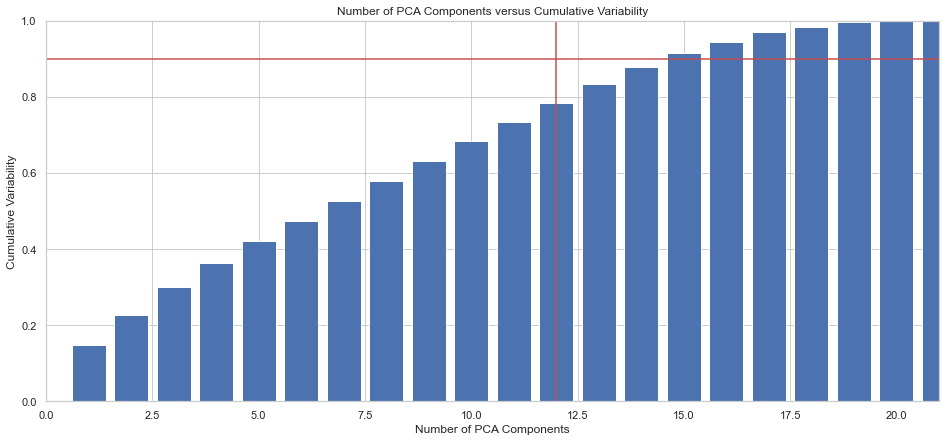

In [18]:
# Plot the cumulative variability against the number of PCA components

fig, ax = plt.subplots(figsize = (16,7))
plt.bar(list(range(1, len(pcaSt.explained_variance_ratio_)+1)), c_v)
plt.hlines(y = 0.9, xmin = 0, xmax = len(c_v), color= 'r')
plt.vlines(x = n, ymin = 0, ymax = 1, color= 'r')
plt.xlim(0,len(c_v))
plt.ylim(0,1)
plt.xlabel('Number of PCA Components',fontsize=12)
plt.ylabel('Cumulative Variability',fontsize = 12)
plt.title('Number of PCA Components versus Cumulative Variability',fontsize=12)
plt.show()

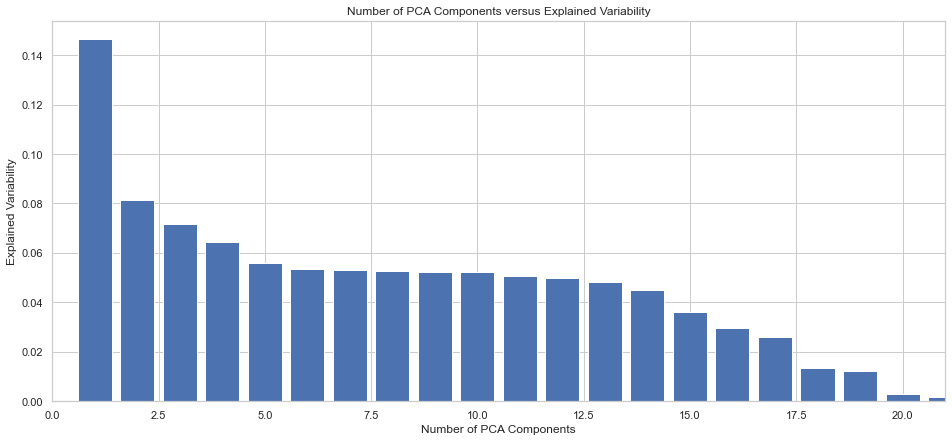

In [19]:
# Plot the cumulative variability against the number of PCA components

fig, ax = plt.subplots(figsize = (16,7))
plt.bar(list(range(1, len(pcaSt.explained_variance_ratio_)+1)), pcaSt.explained_variance_ratio_)
plt.xlim(0,len(c_v))
plt.xlabel('Number of PCA Components',fontsize=12)
plt.ylabel('Explained Variability',fontsize = 12)
plt.title('Number of PCA Components versus Explained Variability',fontsize=12)
plt.show()

### Boosting Classifier

A boosting classifier was explored for multiple sets. For each exploration, the learning rate and the tree depth of the base estimator were tuned. The response variable is the trip count, categorized into: No trips (0), Low Trip Count (1-2), and Large Trip Count (>2). The sets explored are: <br>
- Set A: Predictors [SpecialDate(Binary), UTCI(Categorical), Precipitation(Binary), Weekend(Binary), Hour(Categorical - morning, early afternoon, late afternoon, evening, midnight), Month(Categorical - 1-12)]
- Set B: Predictors [SpecialDate(Binary), UTCI(Continuous), Precipitation(Binary), Weekend(Binary), Hour(Categorical - morning, early afternoon, late afternoon, evening, midnight), Month(Categorical - 1-12)]
- Set C: Predictors [SpecialDate(Binary), DBT(Continuous), RelHum(Continuous), WSp(Continuous), Precipitation(Binary), Weekend(Binary), Hour(Categorical - morning, early afternoon, late afternoon, evening, midnight), Month(Categorical - 1-12)]
- Set D: Predictors [SpecialDate(Binary), UTCI(Continuous), Precipitation(Binary), Weekend(Binary), Hour(Categorical - morning, early afternoon, late afternoon, evening, but excluding midnight), Month(Categorical - 1-12)]
- Set E: Predictors [SpecialDate(Binary), UTCI(Continuous), Precipitation(Binary), Weekend(Binary), Hour(Categorical - morning, early afternoon, late afternoon, evening, midnight), Month(Categorical - 1-12)] excluding all rows with count of 0
- Set F: Predictors [UTCI(Continuous)]
- Set G: Predictors [SpecialDate(Binary), UTCI(Continuous), Precipitation(Binary), Weekend(Binary), Hour(Categorical - 1-24), Month(Categorical - 1-12)]
- Set PCA_B: Predictors are PCAs based on Set B
- Set PCA_E: Predictors are PCAs based on Set E

Those sets were tested and the summary of accuracies is saved at the end of this section, but only the most performing set results are displayed in detail below.

In [20]:
boostingClassifier = {}

#### SetE

In [21]:
# Create full set
X = df.drop(['Year','Day','Hour','Precipitation','utcivar1','utcivar2','utcivar3','count','route','count_cat'],axis =1)

# Adjust dummy variables
month_dm = pd.get_dummies(data=X['Month'], drop_first=True, prefix = 'month')
hour_cat_dm = pd.get_dummies(data=X['hour_cat'], drop_first=True, prefix = 'hour_cat')

X = pd.concat([X,hour_cat_dm,month_dm], axis=1).drop(['Month','hour_cat'], axis=1)

X.head()

X_E = X[df['count']!=0]

# Train test split
X_trainA, X_test, y_trainA, y_test = train_test_split(X_E,y_E,train_size=0.8, random_state=109)

# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_trainA,y_trainA,train_size=0.9, random_state=109)

In [22]:
# Set maximum degree
maxtrees = list(range(40))
maxtrees.pop(0)
maxtrees.pop(0)
maxtrees.pop(0)
maxtrees.pop(0)
maxtrees.pop(0)
maxtrees.pop(0)
maxtrees.pop(0)
l_rates = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]

In [23]:
# Hyperparameter tuning - Max Tree Depths

# Set list to store training and validation errors
training_acc, validation_acc = [], []

# Iterating through max_tree depth
for i in range(len(maxtrees)):
    
    # Create and fit a AdaBoost classifier
    adaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = maxtrees[i], class_weight='balanced'), algorithm = 'SAMME', n_estimators = 50, learning_rate = 0.001)
    adaBoost.fit(X_train,y_train)

    # Predict using the Adaboost
    adaBoost_pred_train = adaBoost.predict(X_train)
    adaBoost_pred_test = adaBoost.predict(X_val)

    # Calculate accuracy on the training and test sets
    adaBoost_train_score = accuracy_score(adaBoost_pred_train, y_train)
    adaBoost_val_score = accuracy_score(adaBoost_pred_test, y_val)
    
    # Compute the train and validation MSE
    training_acc.append(adaBoost_train_score)
    validation_acc.append(adaBoost_val_score)

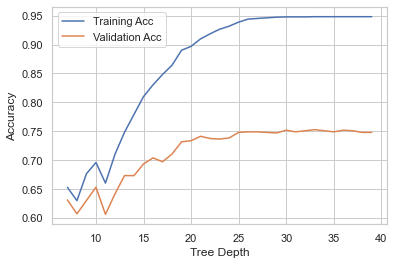

In [24]:
# Compare the validation set errors for different degrees through a plot

fig, ax = plt.subplots()
ax.plot(maxtrees, training_acc, label = 'Training Acc')
ax.plot(maxtrees, validation_acc, label = 'Validation Acc')
ax.set_xlabel('Tree Depth')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')
#ax.set_yscale('log')
plt.show()

In [25]:
# Print the train and validation MSE along with the degree of the best model. 

max_accuracy = max(validation_acc)
best_depth = maxtrees[validation_acc.index(max_accuracy)]

print("The best tree depth of the model is",best_depth)

The best tree depth of the model is 33


In [26]:
# Hyperparameter tuning - Learning rate

# Set list to store training and validation errors
training_acc, validation_acc = [], []

# Iterating through max_tree depth
for i in range(len(l_rates)):
    
    # Create and fit a AdaBoost classifier
    adaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 20, class_weight='balanced'), algorithm = 'SAMME', n_estimators = 50, learning_rate = l_rates[i])
    adaBoost.fit(X_train,y_train)

    # Predict using the Adaboost
    adaBoost_pred_train = adaBoost.predict(X_train)
    adaBoost_pred_test = adaBoost.predict(X_val)

    # Calculate accuracy on the training and test sets
    adaBoost_train_score = accuracy_score(adaBoost_pred_train, y_train)
    adaBoost_val_score = accuracy_score(adaBoost_pred_test, y_val)
    
    # Compute the train and validation MSE
    training_acc.append(adaBoost_train_score)
    validation_acc.append(adaBoost_val_score)

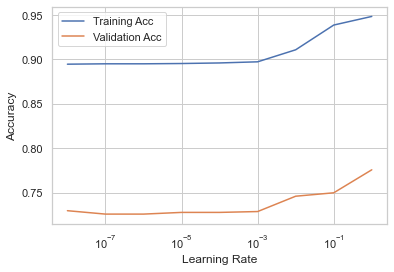

In [27]:
# Compare the validation set errors for different degrees through a plot

fig, ax = plt.subplots()
ax.plot(l_rates, training_acc, label = 'Training Acc')
ax.plot(l_rates, validation_acc, label = 'Validation Acc')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')
ax.set_xscale('log')
plt.show()

In [28]:
# Print the train and validation MSE along with the degree of the best model. 

max_accuracy = max(validation_acc)
best_learningR = l_rates[validation_acc.index(max_accuracy)]

print("The best learning rate of the model is",best_learningR)

The best learning rate of the model is 1


In [29]:
# Create and fit a AdaBoost classifier
adaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = best_depth, class_weight='balanced'), algorithm = 'SAMME', n_estimators = 800, learning_rate = best_learningR)
adaBoost.fit(X_train,y_train)

# Predict using the Adaboost
adaBoost_pred_train = adaBoost.predict(X_train)
adaBoost_pred_test = adaBoost.predict(X_test)

# Calculate accuracy on the training and test sets
adaBoost_train_score = accuracy_score(adaBoost_pred_train, y_train)
adaBoost_test_score = accuracy_score(adaBoost_pred_test, y_test)

# Calculate staged scores
adaBoost_staged_train_score = list(adaBoost.staged_score(X_train,y_train))
adaBoost_staged_test_score = list(adaBoost.staged_score(X_test,y_test))

In [30]:
boostingClassifier['SetE'] = adaBoost_test_score

In [31]:
len(X_train.columns)

21

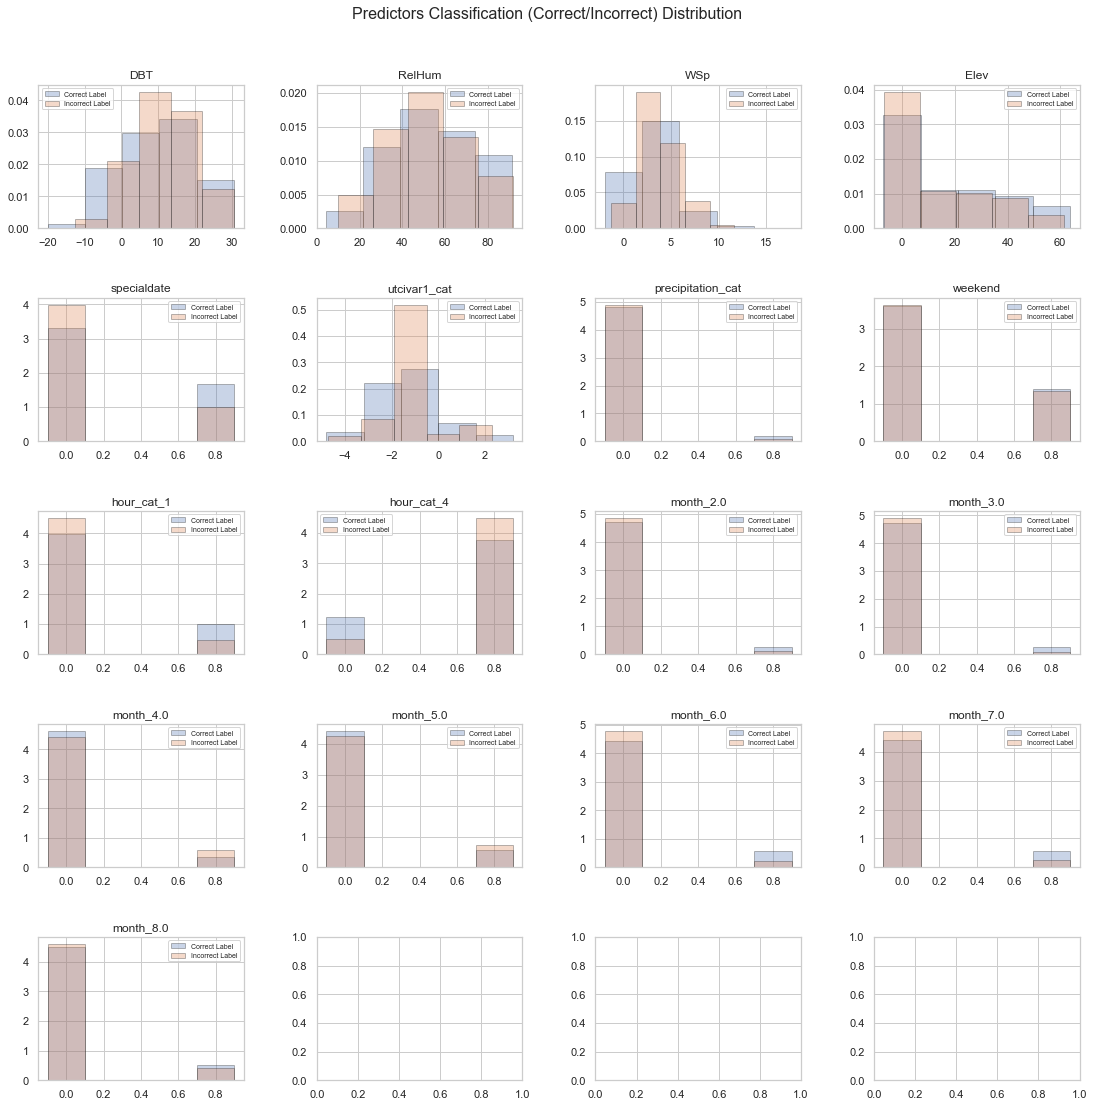

In [32]:
# Plots for each predictor

# Create a list of predictors
predictors = X_train.columns

# Setting subplots
fig, ax = plt.subplots(5, 4,  figsize=(16,16))

for i in range(len(predictors)):
    if(i < 17):
        ax[int(i/4)][i%4].hist(X_test[adaBoost_pred_test == y_test][predictors[i]].values, bins = 5, label = 'Correct Label', align = 'left', density = True, edgecolor='k', alpha = 0.3)
        ax[int(i/4)][i%4].hist(X_test[adaBoost_pred_test != y_test][predictors[i]], bins = 5, label = 'Incorrect Label', align = 'left', density = True, edgecolor='k', alpha = 0.3)

for index, a in enumerate(ax.flat):
    if(index < 17):
   # a.set(ylabel=predictors[index])
        a.set_title(str(predictors[index]))
        a.legend(loc='best',fontsize=7)
    
fig.suptitle('Predictors Classification (Correct/Incorrect) Distribution', fontsize=16)
fig.tight_layout(pad=3.0)

SetA: UTCI Class, <br>
SetB: UTCI Cont, <br>
SetC: Weather Cont, <br>
SetD: Exclude Night, UTCI Cont, <br>
SetE: Exclude 0s, UTCI Cont, <br>
SetG: Hour Cont, UTCI Cont, <br>
SetPCA_B: B, <br>
SetPCA_E: E, <br>

boostingClassifier<br>
{'SetA': 0.5128100854005694, <br>
 'SetB': 0.6228141520943473,<br>
 'SetC': 0.6302358682391216,<br>
 'SetD': 0.517771509167842,<br>
 'SetE': 0.753928708317363,<br>
 'SetPCA_B': 0.6504676697844652,<br>
 'SetPCA_E': 0.7600613261786124,<br>
 'SetG': 0.6530093533956893}

### Boosting Regressor

A boosting regressor was explored for the same sets. For each exploration, the learning rate and the tree depth of the base estimator were tuned. The response variable is the trip count.

In [33]:
boostingRegressor = {}
boostingRegressor_r2 = {}

#### Set B

In [34]:
# Train test split
X_trainA, X_test, y_trainA, y_test = train_test_split(X,y_cont,train_size=0.8, random_state=109)

# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_trainA,y_trainA,train_size=0.9, random_state=109)

In [35]:
# Set maximum degree
maxtrees = list(range(40))
maxtrees.pop(0)
l_rates = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]

In [36]:
# Hyperparameter tuning - Max Tree Depths

# Set list to store training and validation errors
training_error, validation_error = [], []

# Iterating through max_tree depth
for i in range(len(maxtrees)):
    
    # Create and fit a boosting regressor
    gradBoost = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.01, criterion= 'mse', max_depth = maxtrees[i])
    gradBoost.fit(X_train,y_train)

    # Predict using the boosting regressor
    gradBoost_pred_train = gradBoost.predict(X_train)
    gradBoost_pred_val = gradBoost.predict(X_val)

    # Calculate accuracy on the training and test sets
    gradBoost_train_error = mean_squared_error(gradBoost_pred_train, y_train)
    gradBoost_val_error = mean_squared_error(gradBoost_pred_val, y_val)
    
    # Compute the train and validation MSE
    training_error.append(gradBoost_train_error)
    validation_error.append(gradBoost_val_error)

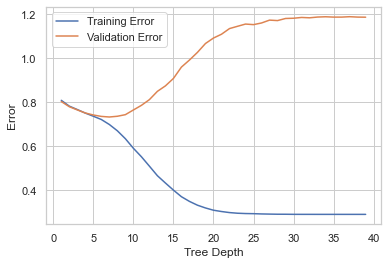

In [37]:
# Compare the validation set errors for different degrees through a plot

fig, ax = plt.subplots()
ax.plot(maxtrees, training_error, label = 'Training Error')
ax.plot(maxtrees, validation_error, label = 'Validation Error')
ax.set_xlabel('Tree Depth')
ax.set_ylabel('Error')
ax.legend(loc = 'best')
#ax.set_yscale('log')
plt.show()

In [38]:
# Print the train and validation MSE along with the degree of the best model. 

min_mse = min(validation_error)
best_depth = maxtrees[validation_error.index(min_mse)]

print("The best tree depth of the model is",best_depth)

The best tree depth of the model is 7


In [39]:
# Hyperparameter tuning - Learning Rates

# Set list to store training and validation errors
training_error, validation_error = [], []

# Iterating through max_tree depth
for i in range(len(l_rates)):
    
    # Create and fit a boosting regressor
    gradBoost = GradientBoostingRegressor(n_estimators = 200, learning_rate = l_rates[i], criterion= 'mse', max_depth = best_depth)
    gradBoost.fit(X_train,y_train)

    # Predict using the boosting regressor
    gradBoost_pred_train = gradBoost.predict(X_train)
    gradBoost_pred_val = gradBoost.predict(X_val)

    # Calculate accuracy on the training and test sets
    gradBoost_train_error = mean_squared_error(gradBoost_pred_train, y_train)
    gradBoost_val_error = mean_squared_error(gradBoost_pred_val, y_val)
    
    # Compute the train and validation MSE
    training_error.append(gradBoost_train_error)
    validation_error.append(gradBoost_val_error)

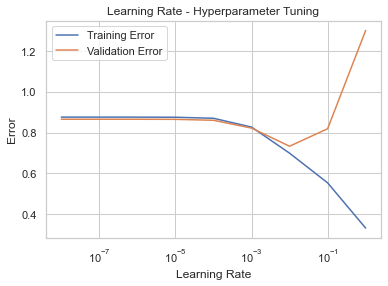

In [40]:
# Compare the validation set errors for different degrees through a plot

fig, ax = plt.subplots()
ax.plot(l_rates, training_error, label = 'Training Error')
ax.plot(l_rates, validation_error, label = 'Validation Error')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Error')
ax.set_title('Learning Rate - Hyperparameter Tuning')
ax.legend(loc = 'best')
ax.set_xscale('log')
plt.show()

In [41]:
# Print the train and validation MSE along with the degree of the best model. 

min_mse = min(validation_error)
best_learningR = l_rates[validation_error.index(min_mse)]

print("The best learning rate of the model is",best_learningR)

The best learning rate of the model is 0.01


In [42]:
# Run the tuned model

# Create and fit a boosting regressor
gradBoost = GradientBoostingRegressor(n_estimators = 200, learning_rate = best_learningR, criterion= 'mse', max_depth = best_depth)
gradBoost.fit(X_train,y_train)

# Predict using the boosting regressor
gradBoost_pred_train = gradBoost.predict(X_train)
gradBoost_pred_test = gradBoost.predict(X_test)

# Calculate error on the training and test sets
gradBoost_train_error = mean_squared_error(gradBoost_pred_train, y_train)
gradBoost_test_error = mean_squared_error(gradBoost_pred_test, y_test)
gradBoost_test_r2_score = r2_score(gradBoost_pred_test, y_test)

# Calculate staged error
gradBoost_staged_train_pred = list(gradBoost.staged_predict(X_train))
gradBoost_staged_test_pred = list(gradBoost.staged_predict(X_test))

In [43]:
boostingRegressor['SetB'] = gradBoost_test_error
boostingRegressor_r2['SetB'] = gradBoost_test_r2_score

In [44]:
# Calculate the mse for the staged predictions
gradBoost_staged_train_error, gradBoost_staged_test_error = [], []

for p in gradBoost_staged_train_pred:
    gradBoost_staged_train_error.append(mean_squared_error(p, y_train))
    
for p in gradBoost_staged_test_pred:
    gradBoost_staged_test_error.append(mean_squared_error(p, y_test))

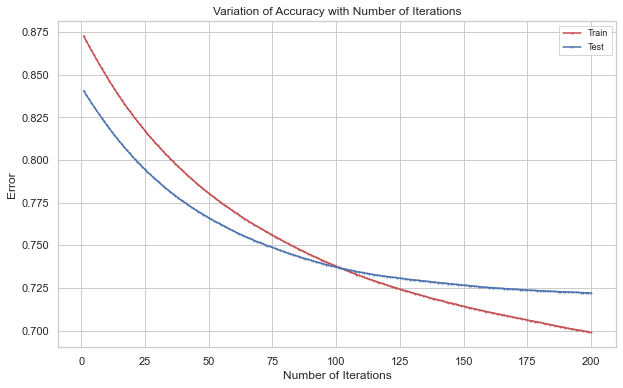

In [45]:
# Plot the effect of the number of estimators on the train and test accuracy
estNum = list(range(1, 201))
plt.figure(figsize=(10,6))
plt.ylabel("Error")
plt.xlabel("Number of Iterations")
#plt.ylim(0.62,0.77)
plt.title('Variation of Accuracy with Number of Iterations')
plt.plot(estNum, gradBoost_staged_train_error, 'r-', marker='o', markersize = 1, label = 'Train')
plt.plot(estNum, gradBoost_staged_test_error, 'b-', marker='o', markersize = 1, label = 'Test')
plt.legend(loc='best',fontsize=9)
plt.show()

The results shown below reflect the MSE for the different regressor models. As can be observed, the r-2 values indicate that the models fit very poorly the data.

MSE

boostingRegressor <br>
{'SetA': 0.7395833913268876, <br>
 'SetB': 0.7418382693248922,<br>
 'SetC': 0.7392530342174273,<br>
 'SetD': 1.048925188673025,<br>
 'SetE': 1.1666408872177203,<br>
 'SetPCA_B': 0.7244772098501476,<br>
 'SetPCA_E': 1.1357364408933217}<br>

boostingRegressor_r2 <br>
{'SetA': -5.985654797112902,<br>
 'SetB': -6.595283859212562,<br>
 'SetC': -6.315554612273073,<br>
 'SetD': -18.473603414425416,<br>
 'SetE': -20.244904370037585,<br>
 'SetPCA_B': -4.5461665002222,<br>
 'SetPCA_E': -12.111670587780976}

# Random Forest model with basic sets A1,A2,B predictors

In [4]:
# Helper function to plot the impurity-based feature importances of the defined model
def plot_feature_importance(model1, model2,X,y):
    
    plt.xkcd(scale=0.3,randomness=0.6)
#     maxlim = max(max(model1.feature_importances_),max(model2.feature_importances_))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for Random Forest
    tree_importance_sorted_idx = np.argsort(model1.feature_importances_)
    tree_indices = np.arange(0, len(model1.feature_importances_)) + 0.5

    ax1.barh(tree_indices, 
           model1.feature_importances_[tree_importance_sorted_idx], 
           height=0.7, color='#B2D7D0')
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], 
                        fontsize=12)
    ax1.set_ylim((0, len(model1.feature_importances_)))
    ax1.set_xlabel("Impurity Based Feature Importance", fontsize=16)

    # Plot for Bagging

    tree_importance_sorted_idx = np.argsort(model2.feature_importances_)
    tree_indices = np.arange(0, len(model2.feature_importances_)) + 0.5
    difference = model2.feature_importances_ - model1.feature_importances_
    difference = difference[tree_importance_sorted_idx]
    

    ax2.barh(tree_indices, model2.feature_importances_[tree_importance_sorted_idx], 
          height=0.7, color='#EFAEA4')
    for index, value in enumerate(model2.feature_importances_[tree_importance_sorted_idx]):
        ax2.text(value, index+0.3, f" {str(round(difference[index],3))}",fontsize=14)

    ax2.set_yticks(tree_indices)
    ax2.set_yticklabels(X.columns[tree_importance_sorted_idx], fontsize=12)
    
    ax2.set_ylim((0, len(model2.feature_importances_)))
    maxlim = max(model2.feature_importances_)
    ax2.set_xlim(0,maxlim+0.02)
    ax2.set_xlabel("Impurity Based Feature Importance", fontsize=16)

    ax1.set_title("Random Forest Classifier", fontsize=18)
    ax2.set_title("Random Forest Regressor", fontsize=18)
    fig.tight_layout()
    plt.show()
    

In [5]:
#get dummies for categorical predictors 
catcols = ['Month','Hour','hour_cat','specialdate','route','utcivar1_cat','precipitation_cat','weekend']
df_og = df.copy()
df = pd.get_dummies(df,columns = catcols, drop_first = False)

In [6]:
X = df.drop(['count','count_cat'],axis = 1)
y_cat = df['count']
y_cts = df['count_cat']
#,stratify = X['precipitation_cat','utcivar1','utcivar1_cat']) 
X_train, X_test, y_cts_train, y_cts_test, y_cat_train,y_cat_test = train_test_split(X,y_cts,y_cat, train_size = 0.8)

In [7]:
#random forest hyperparameters
max_depth = 4 
n_estimators = 146
rs = 42
rfrscores = {}
rfcscores = {}

#Set A1
#utcivar1_cat,precipitation_cat,special_date,weekend,hour_cat,Month
a1cols = ['Month_1.0', 'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0', 'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0',
          'hour_cat_early_afternoon', 'hour_cat_evening', 'hour_cat_late_afternoon', 'hour_cat_midnight', 'hour_cat_morning',
          'specialdate_0', 'specialdate_1',
           'utcivar1_cat_-5', 'utcivar1_cat_-4', 'utcivar1_cat_-3', 'utcivar1_cat_-2', 'utcivar1_cat_-1', 'utcivar1_cat_0', 'utcivar1_cat_1', 'utcivar1_cat_2', 'utcivar1_cat_3', 'utcivar1_cat_4',
            'precipitation_cat_0', 'precipitation_cat_1', 
              'weekend_0', 'weekend_1'
         ]

#utcivar1,precipitation_cat,special_date,weekend,hour_cat,Month
a2cols = ['Month_1.0', 'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0', 'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0',
          'hour_cat_early_afternoon', 'hour_cat_evening', 'hour_cat_late_afternoon', 'hour_cat_midnight', 'hour_cat_morning',
          'specialdate_0', 'specialdate_1',
          'utcivar1',
            'precipitation_cat_0', 'precipitation_cat_1', 
              'weekend_0', 'weekend_1'
         ]

#DBT,RelHum,Wsp,precipitation_cat,special_date,weekend,hour_cat,Month
Bcols = ['Month_1.0', 'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0', 'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0',
           'hour_cat_early_afternoon', 'hour_cat_evening', 'hour_cat_late_afternoon', 'hour_cat_midnight', 'hour_cat_morning',
          'specialdate_0', 'specialdate_1',
            'DBT','RelHum','WSp',
          'precipitation_cat_0', 'precipitation_cat_1', 
              'weekend_0', 'weekend_1'
         ]

In [8]:
def rfmodel(modelcols,modelname,X_train,X_test,y_cat_train,y_cat_test,y_cts_train,y_cts_test,plot):
        
    #RF classifier
    name = 'rfc' + modelname
    rfc = RandomForestClassifier(max_features = 'auto', max_depth = max_depth, n_estimators = n_estimators,
                               random_state = rs,class_weight = "balanced_subsample", oob_score = True)

    rfc.fit(X_train[modelcols],y_cat_train)
    rfc_trainscore = round(rfc.score(X_train[modelcols],y_cat_train),4)
    rfc_testscore = round(rfc.score(X_test[modelcols],y_cat_test),4)
    rfc_oobscore = round(rfc.oob_score_,4)

    rfcscores[name] = [rfc_trainscore,rfc_testscore,rfc_oobscore]

    #RF regressor for A1
    name = 'rfr' + modelname
    rfr = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators,
                                  random_state = rs)
    rfr.fit(X_train[modelcols],y_cts_train)
    rfr_trainscore = round(rfr.score(X_train[modelcols],y_cts_train),4)
    rfr_testscore = round(rfr.score(X_test[modelcols],y_cts_test),4)

    rfrscores[name] = [rfr_trainscore,rfr_testscore]

    #plot feature importance
    if plot: 
        print('Model' + modelname)
        plot_feature_importance(rfc,rfr,X_train[modelcols],y_cts_train)

Modela1


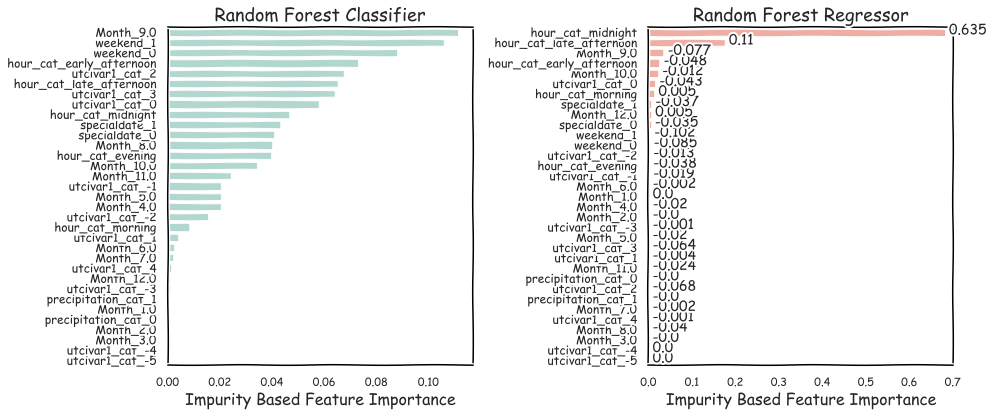

Modela2


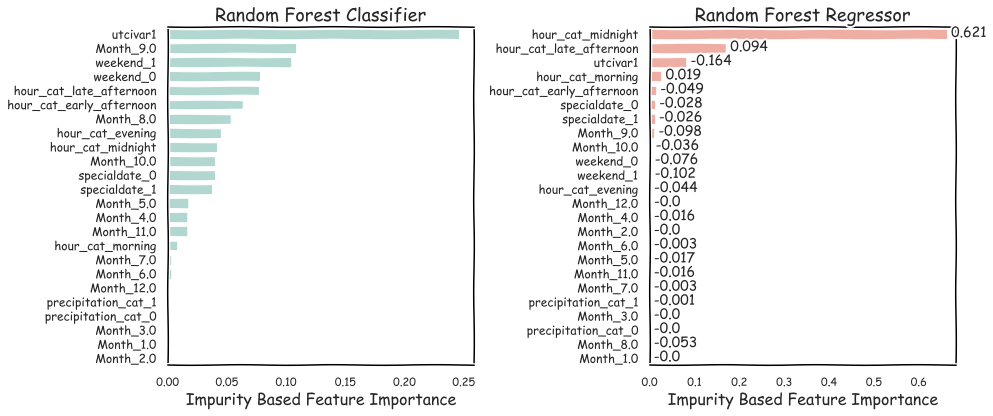

ModelB


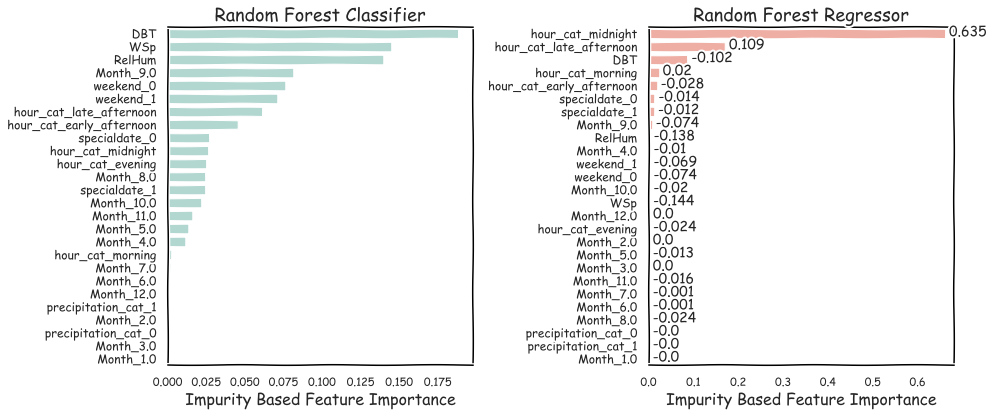

In [9]:
#run models for all sets of predictors
rfmodel(a1cols,'a1',X_train,X_test,y_cat_train,y_cat_test,y_cts_train,y_cts_test,plot = True)
rfmodel(a2cols,'a2',X_train,X_test,y_cat_train,y_cat_test,y_cts_train,y_cts_test,plot = True)
rfmodel(Bcols,'B',X_train,X_test,y_cat_train,y_cat_test,y_cts_train,y_cts_test,plot = True)

### scores for basic sets

In [10]:
rfc_df = pd.DataFrame.from_dict(rfcscores, orient = 'index', columns = ['train score','test score','oob_score'])
rfr_df = pd.DataFrame.from_dict(rfrscores, orient = 'index', columns = ['train score','test score'])
print('Random Forest Classifier\n', rfc_df)
print('\nRandom Forest Regressor\n', rfr_df)

Random Forest Classifier
        train score  test score  oob_score
rfca1       0.3433      0.3362     0.3425
rfca2       0.3754      0.3714     0.3774
rfcB        0.4128      0.4051     0.3975

Random Forest Regressor
        train score  test score
rfra1       0.1398      0.1455
rfra2       0.1426      0.1435
rfrB        0.1431      0.1446


### Remarks

While both random forest classifier and random forest regressor did not perform well, the random forest classifier performed better. 
Overall, the scores are too low. This could be because the sets of predictors are not granular enough. In the next iteration, we change the hour categories to increase granularity (from 5 categories, to 24 categories for 24 hours). We also restrict the data set to just include hours when MIT is in session and when it isn't a public holiday and when it's a weekday.

### random forest with restricted sets of predictors

In [11]:
minHour = 9 #inclusive
maxHour = 12 #inclusive
df2 = df_og.copy()
df2 = df2[(df2['specialdate'] == 0) & (df2['Hour'] <= maxHour) & (df2['Hour'] >= minHour) & (df2['weekend'] == 0 ) ]#& df2['route'] == 1]

In [12]:
#get dummies for categorical predictors 
catcols = ['Month','Hour','hour_cat','route','utcivar1_cat','precipitation_cat','Year']
df2 = pd.get_dummies(df2,columns = catcols, drop_first = False)

In [13]:
X2 = df2.drop(['count','count_cat'],axis = 1)
y2_cat = df2['count']
y2_cts = df2['count_cat']

In [14]:
X2_train, X2_test, y2_cts_train, y2_cts_test, y2_cat_train, y2_cat_test = train_test_split(X2,y2_cts,y2_cat, train_size = 0.8)#,stratify = X['precipitation_cat','utcivar1','utcivar1_cat']) 

In [15]:
max_depth = 4 
n_estimators = 146
rs = 42

In [16]:
#Set A1
#utcivar1_cat,precipitation_cat,special_date,weekend,hour_cat,Month
monthList = ['Month_1.0', 'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0', 'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0']
hourList = ['Hour_0.0', 'Hour_1.0', 'Hour_2.0', 'Hour_3.0', 'Hour_4.0', 'Hour_5.0', 'Hour_6.0', 'Hour_7.0', 'Hour_8.0', 'Hour_9.0', 'Hour_10.0', 'Hour_11.0', 'Hour_12.0', 
            'Hour_13.0', 'Hour_14.0', 'Hour_15.0', 'Hour_16.0', 'Hour_17.0', 'Hour_18.0', 'Hour_19.0', 'Hour_20.0', 'Hour_21.0', 'Hour_22.0', 'Hour_23.0']
utciCatList = ['utcivar1_cat_-5', 'utcivar1_cat_-4', 'utcivar1_cat_-3', 'utcivar1_cat_-2', 'utcivar1_cat_-1', 'utcivar1_cat_0', 'utcivar1_cat_1', 'utcivar1_cat_2', 'utcivar1_cat_3', 'utcivar1_cat_4']
precipitationList = ['precipitation_cat_0', 'precipitation_cat_1']
weatherList = ['DBT','RelHum','WSp']
yearList = ['Year_2017.0', 'Year_2018.0', 'Year_2019.0']
routeList = ['route_1', 'route_2', 'route_3']

a1cols = monthList + hourList[minHour:maxHour+1] + utciCatList + precipitationList + yearList + routeList

a2cols = monthList + hourList[minHour:maxHour+1] + ['utcivar1'] + precipitationList + yearList + routeList

Bcols = monthList + hourList[minHour:maxHour+1] + weatherList + precipitationList + yearList + routeList

Modela1


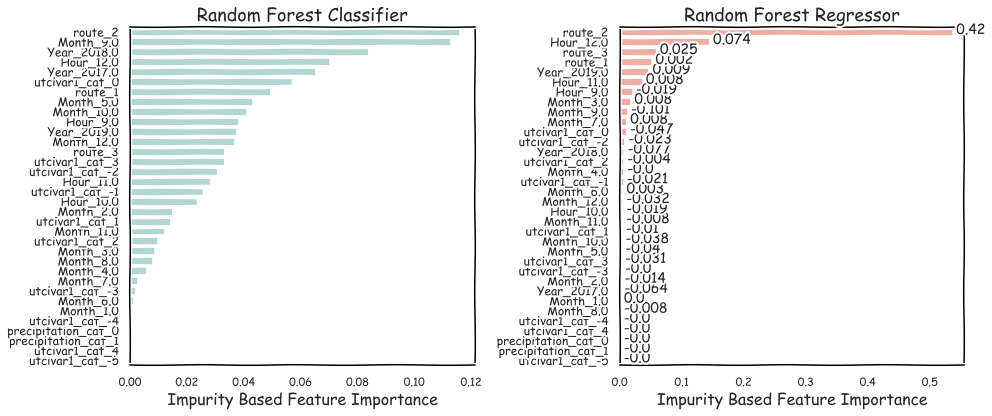

Modela2


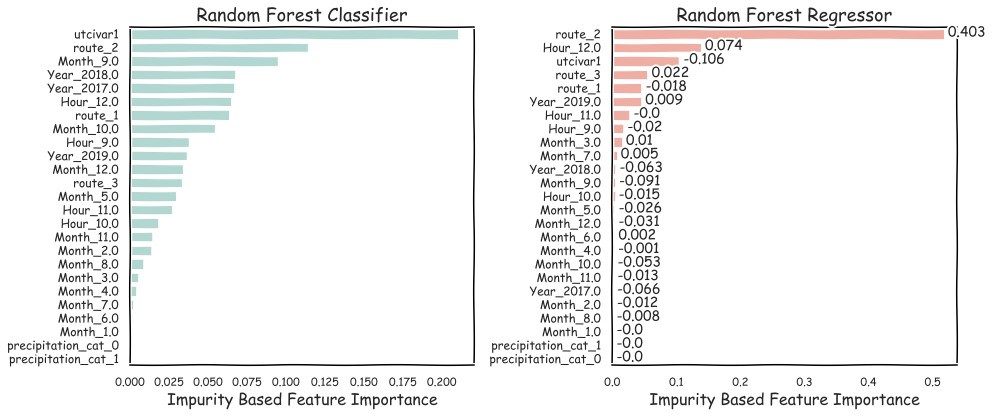

ModelB


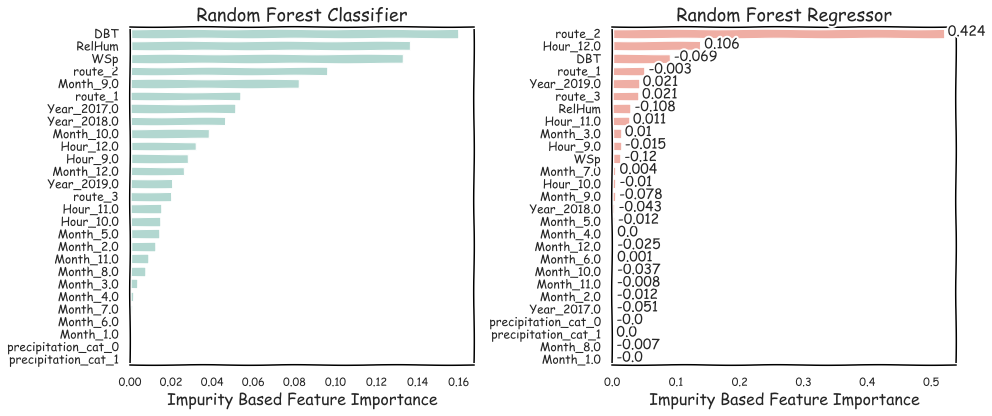

In [17]:
#run models for all sets of predictors
rfrscores = {}
rfcscores = {}
rfmodel(a1cols,'a1',X2_train,X2_test,y2_cat_train,y2_cat_test,y2_cts_train,y2_cts_test,True)
rfmodel(a2cols,'a2',X2_train,X2_test,y2_cat_train,y2_cat_test,y2_cts_train,y2_cts_test,True)
rfmodel(Bcols,'B',X2_train,X2_test,y2_cat_train,y2_cat_test,y2_cts_train,y2_cts_test,True)

In [18]:
rfc_df = pd.DataFrame.from_dict(rfcscores, orient = 'index', columns = ['train score','test score','oob_score'])
rfr_df = pd.DataFrame.from_dict(rfrscores, orient = 'index', columns = ['train score','test score'])
print('Random Forest Classifier\n', rfc_df)
print('\nRandom Forest Regressor\n', rfr_df)

Random Forest Classifier
        train score  test score  oob_score
rfca1       0.5656      0.5528     0.5479
rfca2       0.5616      0.5404     0.5404
rfcB        0.5681      0.5416     0.5398

Random Forest Regressor
        train score  test score
rfra1       0.2375      0.2200
rfra2       0.2457      0.2296
rfrB        0.2461      0.2337


### Remarks

The modifications improved the scores on all predictor sets, especially ‘a1’ and ‘a2’ which involve UTCI. However, the scores are still relatively low and require much improvement.

# KNN

In [19]:
# use function saved in library to categorize variables
df = data_manip(route1, route2, route3)
df.head()

# Sets 
# workday = df[df['Hour'].between(8,18)]
workday = df
a1 = ['Month','utcivar1_cat','specialdate','weekend','precipitation_cat','Hour']
a2 = ['Month','utcivar1','specialdate','weekend','precipitation_cat','Hour']
b = ['Month','specialdate','weekend','precipitation_cat','Hour','DBT', 'RelHum', 'WSp']

feature_sets = [a1,a2,b]
targets = ['count','count_cat']

In [40]:
# Functions 

def scale_split(features,target):
    scaler = MinMaxScaler()
    # Concerned whether each feature should be scaled at one time, but for now simple way
    X = scaler.fit_transform(workday[features])
    y = workday[target]
    # Uses SMOTE for unbalanced classes
    if target == 'count_cat':
        X,y = SMOTE().fit_resample(X,y)

    return train_test_split(X,y,train_size=0.7,random_state=43)

def knn_regress(train_test):
    X_train, X_test, y_train, y_test = train_test
    ps = [1,2]
    ns = np.arange(3,9)
    parameters = {'n_neighbors':ns, 'p':ps}
    knn = KNeighborsRegressor()
    # All combinations grid search    
    regress = GridSearchCV(knn, parameters).fit(X_train,y_train)
    # Uses best model to predict on test set
    test_pred = regress.best_estimator_.predict(X_test)
    score = r2_score(y_test,test_pred)
    mse = mean_squared_error(y_test,test_pred)
    return (mse,score,regress.best_estimator_)

def knn_clf(train_test):
    X_train, X_test, y_train, y_test = train_test
    # Hyper Parameter Sets
    ps = [1,2]
    ns = np.arange(2,9)
    parameters = {'n_neighbors':ns, 'p':ps}
    knn = KNeighborsClassifier()
    # All combinations grid search
    clf = GridSearchCV(knn, parameters).fit(X_train,y_train)
    # Uses best model to predict on test set
    test_pred = clf.best_estimator_.predict(X_test)
    score = r2_score(y_test,test_pred)
    acc = accuracy_score(y_test,test_pred)
    return (acc,score,clf)

In [41]:
r_scores = []
mses = []
best_regress = []
# KNN Regression 
for f_set in feature_sets:
    train_test = scale_split(f_set,targets[0])
    metric,score,best_regre = knn_regress(train_test)
    r_scores.append(score); mses.append(metric); best_regress.append(best_regre)

clf_scores = []
accs = []
best_clfs = []
# KNN Classifier 
for f_set in feature_sets:
    train_test = scale_split(f_set,targets[1])
    metric,score,best_clf = knn_clf(train_test)
    clf_scores.append(score); accs.append(metric); best_clfs.append(best_clf)

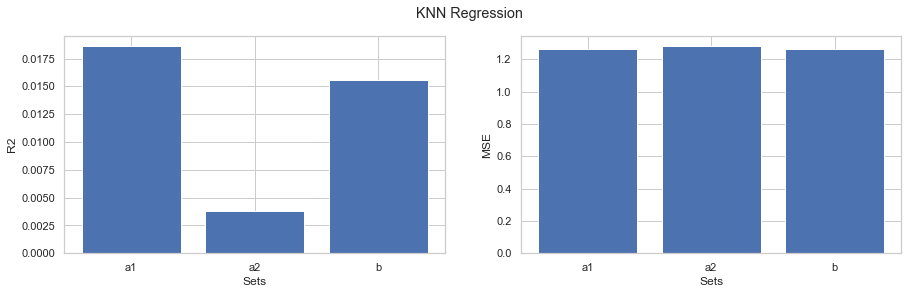

In [42]:
sets = ['a1','a2','b']
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].bar(sets,r_scores)
axes[0].set_xlabel('Sets')
axes[0].set_ylabel('R2')
axes[1].bar(['a1','a2','b'],mses)
axes[1].set_xlabel('Sets')
axes[1].set_ylabel('MSE')
plt.suptitle('KNN Regression');

In [43]:
def report(metric,func):
    val = func(metric)
    ind = metric.index(val)
    return ind

ind = report(mses,min)
print(f'Parameters: {best_regress[ind].get_params}')
print(f'The hyperparameter tuned model with the lowest test mse: {mses[ind]} has a R squared score: {r_scores[ind]} and uses feature set: {sets[ind]}')

The hyperparameter tuned model with the lowest test mse: 1.2613939232409381 has a R squared score: 0.018604985256578055 and uses feature set: a1


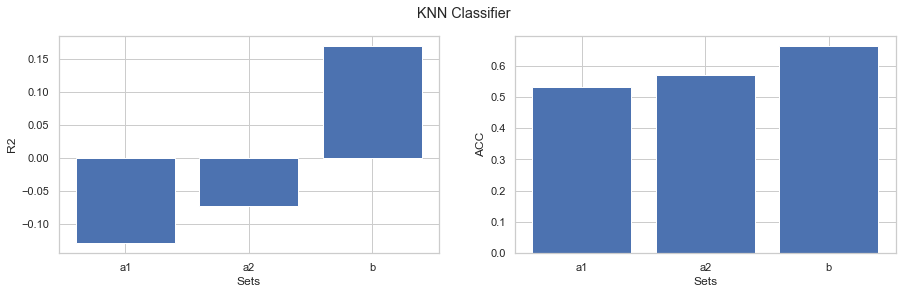

In [44]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].bar(sets,clf_scores)
axes[0].set_xlabel('Sets')
axes[0].set_ylabel('R2')
axes[1].bar(['a1','a2','b'],accs)
axes[1].set_xlabel('Sets')
axes[1].set_ylabel('ACC')
plt.suptitle('KNN Classifier');

In [45]:
ind = report(accs,max)
print(f'Parameters: {best_clfs[ind].get_params}')
print(f'The hyperparameter tuned model with the highest accuracy: {accs[ind]} has a R squared score: {clf_scores[ind]} and uses feature set: {sets[ind]}')

The hyperparameter tuned model with the highest accuracy: 0.6618311533888228 has a R squared score: 0.1694005694198687 and uses feature set: b


# Logistic

### Set predictors

In [14]:
y = df['count_cat']

rs = 109
xtrain_a1, xtest_a1, y_train, y_test = train_test_split(df[a1], y, train_size=0.7, random_state = rs)
xtrain_a2, xtest_a2, y_train, y_test = train_test_split(df[a2], y, train_size=0.7, random_state = rs)
xtrain_b, xtest_b, y_train, y_test = train_test_split(df[b], y, train_size=0.7, random_state = rs)

xtrain_sets = [xtrain_a1, xtrain_a2, xtrain_b]
xtest_sets = [xtest_a1, xtest_a2, xtest_b]

In [37]:
set_names = ['a1','a2','a3']
scores = []
roc_scores = []
for x_train, x_test in zip(xtrain_sets, xtest_sets):
    logit = LogisticRegression(max_iter = 5000, penalty='none').fit(x_train, y_train)
    scores.append(logit.score(x_test, y_test))
    
max_idxs = np.array([index for index, value in enumerate(scores) if value == np.max(scores)])
print('Dataset with highest score:',np.array(set_names)[max_idxs])
print('Highest Accuracy Score:',np.max(scores))

Dataset with highest score: ['a1']
Highest Accuracy Score: 0.7313948759658397
